# Bitcoin price prediction using LSTM and CryptoBERT

Authors : K.H.Fu , J. Garcia Santiago

## Table of contents

---

#### 1. [Introduction](#1)
#### 2. [Data Cleaning for sentiment analysis](#2)
#### 3. [Sentiment Analysis](#3)
#### 4. [Merging Existing dataset](#4)
- 4.1 [Energy Price index dataset processing and merging](#4.1)
- 4.2 [Merging Energy Price index with Bitcoin price](#4.2)
- 4.3 [Add NASDAQ price index to dataset](#4.3)
#### 5. [LSTM modeling](#5)
#### 6. [Limitations](#6)

---
### LSTM models

##### 1. [Model 1](#m1)
##### 2. [Model 2](#m2)
##### 3. [Model 3](#m3)
##### 4. [Model 4](#m4)
##### 5. [Model 5](#m5)
##### 6. [Model 6](#m6)
##### 7. [Model 7](#m7)
##### 8. [Model 8](#m8)
##### 9. [Model 9](#m9)
##### 10 [Results](#c1)
---

## <a name = 1>Introduction</a>

**Bitcoin (BTC)**, the leading cryptocurrency, has emerged as a volatile yet influential asset class with complex price dynamics influenced by diverse factors. Traditional financial indicators (e.g., NASDAQ trends), technical analysis metrics, and market sentiment all play critical roles in shaping its price movements. However, modeling BTC's volatility remains challenging due to its nonlinear dependencies on heterogeneous data sources. <br><br>
This project leverages **Long Short-Term Memory (LSTM) networks** , a specialized recurrent neural network architecture, to predict Bitcoin prices using a multi-modal feature set:
1. Sentiment Analysis: Uses subreddit posts from 2011-2019 to extract sentiment via CryptoBERT, a domain-specific language model fine-tuned for cryptocurrency contexts, to quantify market sentiment from news and social media.
2. Historical Price Data: Open, High, Low, Close (OHLC) values and trading volume.
3. Technical Indicators: Computed metrics such as RSI,and MACD to capture historical price patterns.
4. Macroeconomic Context: NASDAQ Composite Index data and energy price index to account for market correlations. <br>

LSTMs are uniquely suited for this task due to their ability to model temporal dependencies in sequential data, making them ideal for financial time series forecasting. By integrating sentiment scores from CryptoBERT (which contextualizes crypto-specific jargon and narratives) with quantitative market data, this hybrid framework seeks to improve predictive accuracy by capturing both the speculative sentiment-driven volatility and underlying technical/macroeconomic trends.

This notebook documents the end-to-end workflow of feature engineering, model architecture design, and performance evaluation.

## <a name = 2>Data cleaning for sentiment analysis</a>

In [13]:
#IMPORTING NECESSARY LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from random import sample
import re
import torch
from transformers import TextClassificationPipeline, AutoModelForSequenceClassification, AutoTokenizer
import pandas_ta as ta
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [7]:
# DONT PANIC! defining a random state
rs=42

In [8]:
# FUNCTIONS

# REMOVING SPECIAL CHARACTERS
def remove_specials(text):
  # REGEX PATTERNS
  url_pattern = r'https?://\S+|www\.\S+'
  emoji_ranges = r'\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\U00002600-\U000026FF\U00002700-\U000027BF\U0001F1E0-\U0001F1FF'
  regex_pattern = rf'[^A-Za-z0-9_#\'{emoji_ranges}]+'
  user_name_pattern = r'@\w+'
  email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b'
  # PERFORMING REGEX SUBSTITUTION
  new = re.sub(url_pattern, ' ', text)
  new1 = re.sub(email_pattern, ' ', new)
  new2 = re.sub(user_name_pattern, ' ', new1)
  new3 = re.sub(regex_pattern, ' ', new2)
  #STRIPPING EXTRA
  new4 = new3.strip().lower()
  return new4

# SAMPLING TO REDUCE DATASET SIZE
def sample_date(group):
  return group.sample(n=min(50, len(group)), replace=False, random_state=rs)

In [14]:
# Read all reddit posts under subreddit of bitcoin
data1 = pd.read_csv('bitcoin_reddit_all.csv', usecols=['date','body'])
df1 = data1.copy()
df1.head()

/var/folders/y7/dd5xlwgs3z70srh369kvwnz40000gn/T/ipykernel_57932/2950331777.py:2: DtypeWarning: Columns (2,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data1 = pd.read_csv('bitcoin_reddit_all.csv', usecols=['date','body'])


(4309244, 2)

In [10]:
# Change the date format to pandas datetime.
df1['date'] = pd.to_datetime(df1['date'])

In [11]:
# Check if the dataset have missing dates

full_dates = pd.date_range(start='2009-05-08', end='2019-12-31', freq='D')
missing_dates = full_dates[~full_dates.isin(df1['date'])]

# Print results
print("Missing dates (Front):")
print(missing_dates[:10])
print("Missing dates (Rear):")
print(missing_dates[-10:])

Missing dates (Front):
DatetimeIndex(['2009-05-09', '2009-05-10', '2009-05-11', '2009-05-12',
               '2009-05-13', '2009-05-14', '2009-05-15', '2009-05-16',
               '2009-05-17', '2009-05-18'],
              dtype='datetime64[ns]', freq=None)
Missing dates (Rear):
DatetimeIndex(['2011-02-14', '2011-02-18', '2011-02-19', '2011-02-20',
               '2011-03-06', '2011-03-13', '2011-03-17', '2011-04-02',
               '2011-04-09', '2011-04-13'],
              dtype='datetime64[ns]', freq=None)


#### The dataset will not have missing dates fafter 2011-04-13

In [13]:
# Selecting data starting from 2011-04-03
df1 = df1.sort_values( by = 'date', ascending = True)
df1 = df1[df1['date'] >= '2011-04-13']
df1 = df1.drop_duplicates()

In [14]:
# Grouping data using date and reset index for further analysis
reduced_df1 = df1.groupby('date').apply(sample_date)
reduced_df1 = reduced_df1.reset_index(drop=True)
reduced_df1

/var/folders/y7/dd5xlwgs3z70srh369kvwnz40000gn/T/ipykernel_82088/3878436510.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reduced_df1 = df1.groupby('date').apply(sample_date)


,date,body
0,2011-04-14,I'll bet you 5BTC I can program an artificial ...
1,2011-04-14,This is obviously one of the big issues of our...
2,2011-04-14,It would be interesting to have a Bitcoin clie...
3,2011-04-14,I think for the case of a market in the real w...
4,2011-04-14,"Bitcoin is just like cash, just virtual and wi..."
...,...,...
153412,2019-12-31,"Ahh, no, I'm pointing out the other side of th..."
153413,2019-12-31,You missed the point; the point wasn't about C...
153414,2019-12-31,Buy Bitcoin the moment it hits the market and ...
153415,2019-12-31,I never thought Saiko was a bad dude. He was s...


In [15]:
#Removing invalid characters
reduced_df1['body'] = reduced_df1['body'].apply(remove_specials)
reduced_df1

,date,body
0,2011-04-14,i'll bet you 5btc i can program an artificial ...
1,2011-04-14,this is obviously one of the big issues of our...
2,2011-04-14,it would be interesting to have a bitcoin clie...
3,2011-04-14,i think for the case of a market in the real w...
4,2011-04-14,bitcoin is just like cash just virtual and wit...
...,...,...
153412,2019-12-31,ahh no i'm pointing out the other side of the ...
153413,2019-12-31,you missed the point the point wasn't about cr...
153414,2019-12-31,buy bitcoin the moment it hits the market and ...
153415,2019-12-31,i never thought saiko was a bad dude he was sp...


In [16]:
# Adding a column of "text length" for model input
reduced_df1['text_length'] = [len(text) for text in reduced_df1['body']]
reduced_df1.head()

,date,body,text_length
0,2011-04-14,i'll bet you 5btc i can program an artificial ...,161
1,2011-04-14,this is obviously one of the big issues of our...,709
2,2011-04-14,it would be interesting to have a bitcoin clie...,389
3,2011-04-14,i think for the case of a market in the real w...,293
4,2011-04-14,bitcoin is just like cash just virtual and wit...,699


## <a name = 3>Sentiment Analysis</a>

CryptoBERT is used in this project, its a pre-trained NLP model to analyse the language and sentiments of cryptocurrency-related social media posts and messages. It was built by further training the vinai's bertweet-base language model on the cryptocurrency domain. For more details, please visit huggingface website for this model.
[CryptoBERT](https://huggingface.co/ElKulako/cryptobert)

In [19]:
#Import CryptoBERT from Huggingface
model_name = "ElKulako/cryptobert"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [20]:
# Setup pipeline
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, max_length=64, truncation=True, padding = 'max_length', batch_size=64, torch_dtype=torch.float16)

Device set to use mps:0


In [21]:
# Mapping the outputs of sentiment and confidence to dataframe
outputs = pipe(reduced_df1['body'].tolist())
reduced_df1['sentiment'] = [i['label'] for i in outputs]
reduced_df1['score'] = [i['score'] for i in outputs]
labels = {'Bearish':-1, 'Neutral':0, 'Bullish':1}
reduced_df1['sentiment'] = reduced_df1['sentiment'].map(labels)
reduced_df1

,date,body,text_length,sentiment,score
0,2011-04-14,i'll bet you 5btc i can program an artificial ...,161,0,0.746289
1,2011-04-14,this is obviously one of the big issues of our...,709,0,0.666235
2,2011-04-14,it would be interesting to have a bitcoin clie...,389,0,0.709303
3,2011-04-14,i think for the case of a market in the real w...,293,1,0.659130
4,2011-04-14,bitcoin is just like cash just virtual and wit...,699,1,0.674220
...,...,...,...,...,...
153412,2019-12-31,ahh no i'm pointing out the other side of the ...,157,0,0.716051
153413,2019-12-31,you missed the point the point wasn't about cr...,340,0,0.614596
153414,2019-12-31,buy bitcoin the moment it hits the market and ...,92,1,0.526849
153415,2019-12-31,i never thought saiko was a bad dude he was sp...,305,1,0.807559


sentiment
 0    86064
 1    53151
-1    14202
Name: count, dtype: int64


<Axes: xlabel='sentiment', ylabel='count'>

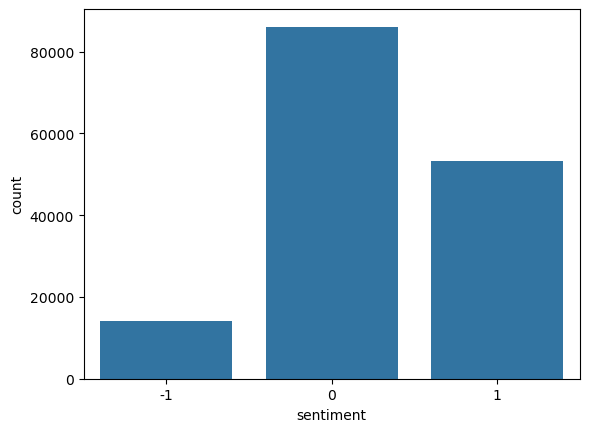

In [22]:
# Plotting the distribution of the sentiment
plot_df = reduced_df1['sentiment'].value_counts()
print(plot_df)
sns.barplot(plot_df)

We can tell people are generally positive towards the crypto market

In [24]:
# Group dataframe for merging
sentiment_df = reduced_df1.groupby('date')[['sentiment', 'score']].mean()
sentiment_df = sentiment_df.reset_index()

# Commented as it's used for saving the dataset
#sentiment_df.to_csv('/content/drive/My Drive/df1.csv')
# sentiment_df = pd.read_csv('/content/drive/My Drive/df1.csv')

Thats the end of the sentiment analysis part.

## <a name = 4>Merging existing dataset</a>

In [27]:
sentiment_df.head()

,date,sentiment,score
0,2011-04-14,0.333333,0.722168
1,2011-04-15,-0.100000,0.654836
2,2011-04-16,0.233333,0.636617
3,2011-04-17,0.020000,0.665158
4,2011-04-18,0.259259,0.638368


### <a name = 4.1>Energy Price index dataset processing and merging

In [29]:
# Read the power-price csv file
data_energy = pd.read_csv('PNRGINDEXM.csv')
df_energy = data_energy.copy()
df_energy.head()

,observation_date,PNRGINDEXM
0,2011-01-01,208.932672
1,2011-02-01,216.000529
2,2011-03-01,233.841822
3,2011-04-01,250.730027
4,2011-05-01,238.786784


In [30]:
# Crop the dataset to fit our analysis date range

df_energy = df_energy[df_energy['observation_date'] >= '2011-03-13']
df_energy = df_energy[df_energy['observation_date'] <= '2019-12-31']

In [31]:
# Ensure the date columns are in datetime format
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
df_energy['observation_date'] = pd.to_datetime(df_energy['observation_date'])

# Extract Year and Month for merging
sentiment_df['year'] = sentiment_df['date'].dt.year
sentiment_df['month'] = sentiment_df['date'].dt.month
df_energy['year'] = df_energy['observation_date'].dt.year
df_energy['month'] = df_energy['observation_date'].dt.month

# Merge sentiment analysis and energy data on Year and Month
merged_sent_ener = sentiment_df.merge(df_energy[['year', 'month', 'PNRGINDEXM']], on=['year', 'month'], how='left')

# Rename the merged column
merged_sent_ener.rename(columns={'PNRGINDEXM': 'price_index'}, inplace=True)

# Drop extra columns
merged_sent_ener.drop(columns=['year', 'month'], inplace=True)


In [32]:
merged_sent_ener

,date,sentiment,score,price_index
0,2011-04-14,0.333333,0.722168,250.730027
1,2011-04-15,-0.100000,0.654836,250.730027
2,2011-04-16,0.233333,0.636617,250.730027
3,2011-04-17,0.020000,0.665158,250.730027
4,2011-04-18,0.259259,0.638368,250.730027
...,...,...,...,...
3179,2019-12-27,0.360000,0.664354,131.104220
3180,2019-12-28,0.260000,0.645188,131.104220
3181,2019-12-29,0.300000,0.637598,131.104220
3182,2019-12-30,0.220000,0.664661,131.104220


### <a name = 4.2>Merging Energy Price index with Bitcoin price 

In [34]:
# Load the bitcoin price csv file
bitcoin_df = pd.read_csv('combined.csv', usecols=['timeOpen','open','high','low','close','volume','marketCap'])

In [35]:
bitcoin_df.head()

,timeOpen,open,high,low,close,volume,marketCap
0,2011-01-01T00:00:00.000Z,0.299929,0.322333,0.268502,0.300000,2810.26,1508662.50
1,2011-01-02T00:00:00.000Z,0.300264,0.367208,0.289348,0.300000,5350.48,1511302.50
2,2011-01-03T00:00:00.000Z,0.300137,0.338386,0.277848,0.297348,1427.50,1500259.79
3,2011-01-04T00:00:00.000Z,0.297227,0.310119,0.248605,0.299439,1883.39,1512924.00
4,2011-01-05T00:00:00.000Z,0.300773,0.392055,0.288454,0.299252,356.98,1514282.20


In [36]:
# Formatting date column for merging
bitcoin_df.rename(columns={'timeOpen': 'date'}, inplace=True)
bitcoin_df['date'] = pd.to_datetime(bitcoin_df['date'])
bitcoin_df = bitcoin_df[bitcoin_df['date'] >= '2011-04-14']
bitcoin_df['date'] = bitcoin_df['date'].dt.tz_localize(None)
bitcoin_df

,date,open,high,low,close,volume,marketCap
103,2011-04-14,0.921805,1.241101,0.920459,0.992989,3.106922e+04,5.878423e+06
104,2011-04-15,0.994289,1.127513,0.952245,0.980247,5.043338e+04,5.809702e+06
105,2011-04-16,0.980726,1.210086,0.940289,1.066647,2.890397e+04,6.331002e+06
106,2011-04-17,1.066684,1.340495,1.021181,1.111174,2.404304e+04,6.605288e+06
107,2011-04-18,1.109214,1.233464,0.934179,1.134944,2.755835e+04,6.754990e+06
...,...,...,...,...,...,...,...
3282,2019-12-27,7238.141180,7363.529235,7189.933935,7290.088518,2.277736e+10,1.321395e+11
3283,2019-12-28,7289.031130,7399.040889,7286.905172,7317.990034,2.136567e+10,1.326591e+11
3284,2019-12-29,7317.647588,7513.948409,7279.865468,7422.652589,2.244526e+10,1.345708e+11
3285,2019-12-30,7420.272788,7454.824027,7276.308140,7292.995078,2.287413e+10,1.322351e+11


In [37]:
# Merge sentiment analysis and energy price index with bitcoin prices
merged_sent_ener['date'] = pd.to_datetime(merged_sent_ener['date'])
final_df_1 = bitcoin_df.merge(merged_sent_ener, on='date', how='left')
#final_df_1.drop(columns=['Unnamed: 0'], inplace=True)
final_df_1

,date,open,high,low,close,volume,marketCap,sentiment,score,price_index
0,2011-04-14,0.921805,1.241101,0.920459,0.992989,3.106922e+04,5.878423e+06,0.333333,0.722168,250.730027
1,2011-04-15,0.994289,1.127513,0.952245,0.980247,5.043338e+04,5.809702e+06,-0.100000,0.654836,250.730027
2,2011-04-16,0.980726,1.210086,0.940289,1.066647,2.890397e+04,6.331002e+06,0.233333,0.636617,250.730027
3,2011-04-17,1.066684,1.340495,1.021181,1.111174,2.404304e+04,6.605288e+06,0.020000,0.665158,250.730027
4,2011-04-18,1.109214,1.233464,0.934179,1.134944,2.755835e+04,6.754990e+06,0.259259,0.638368,250.730027
...,...,...,...,...,...,...,...,...,...,...
3179,2019-12-27,7238.141180,7363.529235,7189.933935,7290.088518,2.277736e+10,1.321395e+11,0.360000,0.664354,131.104220
3180,2019-12-28,7289.031130,7399.040889,7286.905172,7317.990034,2.136567e+10,1.326591e+11,0.260000,0.645188,131.104220
3181,2019-12-29,7317.647588,7513.948409,7279.865468,7422.652589,2.244526e+10,1.345708e+11,0.300000,0.637598,131.104220
3182,2019-12-30,7420.272788,7454.824027,7276.308140,7292.995078,2.287413e+10,1.322351e+11,0.220000,0.664661,131.104220


In [38]:
# Add technical indicators RSI and MACD
final_df_1['bitcoin_rsi'] = ta.rsi(final_df_1['close'], length=14)
final_df_1.ta.macd(append=True)
# Croping the dataset to prevent null values in column RSI and MACD 
final_df_w_TI = final_df_1[final_df_1['date'] >= '2011-05-17']
final_df_w_TI.head()

,date,open,high,low,close,volume,marketCap,sentiment,score,price_index,bitcoin_rsi,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
33,2011-05-17,8.346647,8.776039,6.883945,8.248011,35225.15,51429440.78,0.04,0.620833,238.786784,95.095235,1.796590,0.404795,1.391795
34,2011-05-18,8.224915,8.602457,6.807544,7.307224,25438.60,45668869.87,0.12,0.598172,238.786784,76.950280,1.739637,0.278274,1.461363
35,2011-05-19,7.306953,7.688093,6.343350,7.609671,24512.59,47624177.07,0.16,0.638370,238.786784,78.378597,1.699318,0.190364,1.508954
36,2011-05-20,7.576836,7.592824,4.977627,5.719694,44373.23,35858907.89,0.24,0.635717,238.786784,55.312534,1.497597,-0.009086,1.506683
37,2011-05-21,5.719747,6.998835,5.373052,6.834984,31162.96,42926262.83,0.20,0.649788,238.786784,62.353284,1.411455,-0.076182,1.487637


In [39]:
"""list1['date'] = pd.to_datetime(list1['date'])
final_df_w_TI = list1.merge(final_df_1, on='date', how='left')
final_df_w_TI"""

"list1['date'] = pd.to_datetime(list1['date'])\nfinal_df_w_TI = list1.merge(final_df_1, on='date', how='left')\nfinal_df_w_TI"

In [40]:
#Commented as it's used for saving the dataset
#final_df_w_TI.to_csv('/content/drive/My Drive/bitcoin_lstm_project_data.csv')

### <a name = 4.3>Add NASDAQ price index to dataset

In [42]:
# Read csv
nasdaq_df = pd.read_csv('nasdaq_tech.csv')

In [43]:
# Drop duplicates and rename column to prevent confusion
nasdaq_df= nasdaq_df.drop_duplicates()
nasdaq_df=nasdaq_df.rename(columns={'Date': 'date',
                          'Open': 'open_ndq',
                          'High': 'high_ndq',
                          'Low': 'low_ndq',
                          'Close ': 'close_ndq',
                          'Adj Close': 'adj_close_ndq',})
nasdaq_df.head()

,date,open_ndq,high_ndq,low_ndq,close_ndq,Adj Close
0,NaN,NaN,NaN,NaN,NaN,NaN
1,"Dec 30, 2019","5,474.24","5,474.24","5,407.28","5,441.67","5,441.67"
2,"Dec 27, 2019","5,510.97","5,511.48","5,466.25","5,480.09","5,480.09"
3,"Dec 26, 2019","5,483.12","5,497.59","5,475.48","5,492.35","5,492.35"
4,"Dec 24, 2019","5,475.09","5,476.22","5,456.08","5,471.91","5,471.91"


#### Since the Nasdaq stock market is closed on weekends (Saturdays and Sundays), there are no new price updates on those days. However, we would like to maintain a continuous time series without missing values.
<ul>To ensure that every day in the dataset has a corresponding value, we map the last available closing price to weekends. This means that for any missing Saturday or Sunday price data, we use the closing price from the most recent trading day (typically Friday)</ul>

In [45]:
# Manually add the missing day at the end of dataset
nasdaq_df.loc[0, 'date'] = 'Dec 31, 2019'
nasdaq_df

,date,open_ndq,high_ndq,low_ndq,close_ndq,Adj Close
0,"Dec 31, 2019",NaN,NaN,NaN,NaN,NaN
1,"Dec 30, 2019","5,474.24","5,474.24","5,407.28","5,441.67","5,441.67"
2,"Dec 27, 2019","5,510.97","5,511.48","5,466.25","5,480.09","5,480.09"
3,"Dec 26, 2019","5,483.12","5,497.59","5,475.48","5,492.35","5,492.35"
4,"Dec 24, 2019","5,475.09","5,476.22","5,456.08","5,471.91","5,471.91"
...,...,...,...,...,...,...
2166,"May 23, 2011","1,432.86","1,436.29","1,425.82","1,429.69","1,429.69"
2167,"May 20, 2011","1,458.76","1,466.10","1,450.34","1,456.10","1,456.10"
2168,"May 19, 2011","1,463.26","1,464.03","1,448.20","1,461.50","1,461.50"
2169,"May 18, 2011","1,444.09","1,465.05","1,442.87","1,461.50","1,461.50"


#### Forward Filling missing values 

In [47]:
# Ensure datetime format and set 'date' as index
nasdaq_df['date'] = pd.to_datetime(nasdaq_df['date'])  
nasdaq_df = nasdaq_df.set_index('date')  
# Create a complete daily date range 
full_dates = pd.date_range(start=nasdaq_df.index.min(), end=nasdaq_df.index.max(), freq='D')
# Reindex the DataFrame to include all dates
nasdaq_df = nasdaq_df.reindex(full_dates)
#  Forward filling missing weekend values
nasdaq_df.ffill(inplace=True)  # Forward Fill (Recommended)
nasdaq_df = nasdaq_df.reset_index().rename(columns={'index': 'date'})

nasdaq_df.head()


,date,open_ndq,high_ndq,low_ndq,close_ndq,Adj Close
0,2011-05-17,"1,438.31","1,444.13","1,426.46","1,440.47","1,440.47"
1,2011-05-18,"1,444.09","1,465.05","1,442.87","1,461.50","1,461.50"
2,2011-05-19,"1,463.26","1,464.03","1,448.20","1,461.50","1,461.50"
3,2011-05-20,"1,458.76","1,466.10","1,450.34","1,456.10","1,456.10"
4,2011-05-21,"1,458.76","1,466.10","1,450.34","1,456.10","1,456.10"


In [48]:
# Merge NASDAQ values to existing dataframe.
nasdaq_df['date'] = pd.to_datetime(nasdaq_df['date'])
model_df = nasdaq_df.merge(final_df_w_TI, on='date', how='left')
model_df = model_df.drop(columns=['Adj Close '])
model_df

,date,open_ndq,high_ndq,low_ndq,close_ndq,open,high,low,close,volume,marketCap,sentiment,score,price_index,bitcoin_rsi,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
0,2011-05-17,"1,438.31","1,444.13","1,426.46","1,440.47",8.346647,8.776039,6.883945,8.248011,3.522515e+04,5.142944e+07,0.04,0.620833,238.786784,95.095235,1.796590,0.404795,1.391795
1,2011-05-18,"1,444.09","1,465.05","1,442.87","1,461.50",8.224915,8.602457,6.807544,7.307224,2.543860e+04,4.566887e+07,0.12,0.598172,238.786784,76.950280,1.739637,0.278274,1.461363
2,2011-05-19,"1,463.26","1,464.03","1,448.20","1,461.50",7.306953,7.688093,6.343350,7.609671,2.451259e+04,4.762418e+07,0.16,0.638370,238.786784,78.378597,1.699318,0.190364,1.508954
3,2011-05-20,"1,458.76","1,466.10","1,450.34","1,456.10",7.576836,7.592824,4.977627,5.719694,4.437323e+04,3.585891e+07,0.24,0.635717,238.786784,55.312534,1.497597,-0.009086,1.506683
4,2011-05-21,"1,458.76","1,466.10","1,450.34","1,456.10",5.719747,6.998835,5.373052,6.834984,3.116296e+04,4.292626e+07,0.20,0.649788,238.786784,62.353284,1.411455,-0.076182,1.487637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3146,2019-12-27,"5,510.97","5,511.48","5,466.25","5,480.09",7238.141180,7363.529235,7189.933935,7290.088518,2.277736e+10,1.321395e+11,0.36,0.664354,131.104220,47.746683,-86.832658,48.225876,-135.058534
3147,2019-12-28,"5,510.97","5,511.48","5,466.25","5,480.09",7289.031130,7399.040889,7286.905172,7317.990034,2.136567e+10,1.326591e+11,0.26,0.645188,131.104220,48.619614,-76.325968,46.986053,-123.312021
3148,2019-12-29,"5,510.97","5,511.48","5,466.25","5,480.09",7317.647588,7513.948409,7279.865468,7422.652589,2.244526e+10,1.345708e+11,0.30,0.637598,131.104220,51.867865,-58.875269,51.549402,-110.424671
3149,2019-12-30,"5,474.24","5,474.24","5,407.28","5,441.67",7420.272788,7454.824027,7276.308140,7292.995078,2.287413e+10,1.322351e+11,0.22,0.664661,131.104220,47.833498,-54.875175,44.439596,-99.314771


In [103]:
# Commented as it's used for saving the dataset
# model_df.to_csv('/content/drive/My Drive/V2_bitcoin_lstm_project_data.csv')

#### Till this point, the dataset is ready for feeding to the model 

## <a name = 5>LSTM NN MODEL (Ling Short Term Memory Neural Network)</a>

In [36]:
# Loading dataset
data_RNN_1 = pd.read_csv('/Users/siuuufuuu/Desktop/Bitcoin Prj/V2_bitcoin_lstm_project_data.csv',usecols =['date','close_ndq','open','high','low','close','volume','marketCap','sentiment','score','price_index','bitcoin_rsi','MACD_12_26_9','MACDh_12_26_9','MACDs_12_26_9'])
data_RNN = data_RNN_1.copy()
data_RNN.head()

,date,close_ndq,open,high,low,close,volume,marketCap,sentiment,score,price_index,bitcoin_rsi,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
0,2011-05-17,"1,440.47",8.346647,8.776039,6.883945,8.248011,35225.15,51429440.78,0.04,0.620833,238.786784,95.095235,1.796590,0.404795,1.391795
1,2011-05-18,"1,461.50",8.224915,8.602457,6.807544,7.307224,25438.60,45668869.87,0.12,0.598172,238.786784,76.950280,1.739637,0.278274,1.461363
2,2011-05-19,"1,461.50",7.306953,7.688093,6.343350,7.609671,24512.59,47624177.07,0.16,0.638370,238.786784,78.378597,1.699318,0.190364,1.508954
3,2011-05-20,"1,456.10",7.576836,7.592824,4.977627,5.719694,44373.23,35858907.89,0.24,0.635717,238.786784,55.312534,1.497597,-0.009086,1.506683
4,2011-05-21,"1,456.10",5.719747,6.998835,5.373052,6.834984,31162.96,42926262.83,0.20,0.649788,238.786784,62.353284,1.411455,-0.076182,1.487637


In [38]:
# Shifting dataset upwards for time series analysis
data_RNN['close'] = data_RNN['close'].shift(-1)

In [40]:
# Drop date column as dataframe is already sorted according to date
data_RNN = data_RNN.drop(columns=['date'])

In [42]:
# Convert the date to the correct format
for col in ['close_ndq']:
    data_RNN[col] = data_RNN[col].replace(',', '', regex=True).astype(float)

In [44]:
data_RNN.head()

,close_ndq,open,high,low,close,volume,marketCap,sentiment,score,price_index,bitcoin_rsi,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
0,1440.47,8.346647,8.776039,6.883945,7.307224,35225.15,51429440.78,0.04,0.620833,238.786784,95.095235,1.796590,0.404795,1.391795
1,1461.50,8.224915,8.602457,6.807544,7.609671,25438.60,45668869.87,0.12,0.598172,238.786784,76.950280,1.739637,0.278274,1.461363
2,1461.50,7.306953,7.688093,6.343350,5.719694,24512.59,47624177.07,0.16,0.638370,238.786784,78.378597,1.699318,0.190364,1.508954
3,1456.10,7.576836,7.592824,4.977627,6.834984,44373.23,35858907.89,0.24,0.635717,238.786784,55.312534,1.497597,-0.009086,1.506683
4,1456.10,5.719747,6.998835,5.373052,6.670362,31162.96,42926262.83,0.20,0.649788,238.786784,62.353284,1.411455,-0.076182,1.487637


In [46]:
# Assign predictors and response variable
X = data_RNN.drop(columns=['close'])
y = data_RNN[['close']]
# Manually assign the closing price on 2021/1/1 as a result of shifting
y.loc[3150,'close'] = 7200.17439274
y

/var/folders/y7/dd5xlwgs3z70srh369kvwnz40000gn/T/ipykernel_57932/1403787818.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[3150,'close'] = 7200.17439274


,close
0,7.307224
1,7.609671
2,5.719694
3,6.834984
4,6.670362
...,...
3146,7317.990034
3147,7422.652589
3148,7292.995078
3149,7193.598978


#### Spliting dataset into training, validation and testest. 

In [49]:
X_train, y_train = X[0:2835], y[0:2835]
X_val, y_val =  X[2835:2993], y[2835:2993]
X_test, y_test = X[2993:], y[2993:]

#### Plot the ratio of training, validation and test set

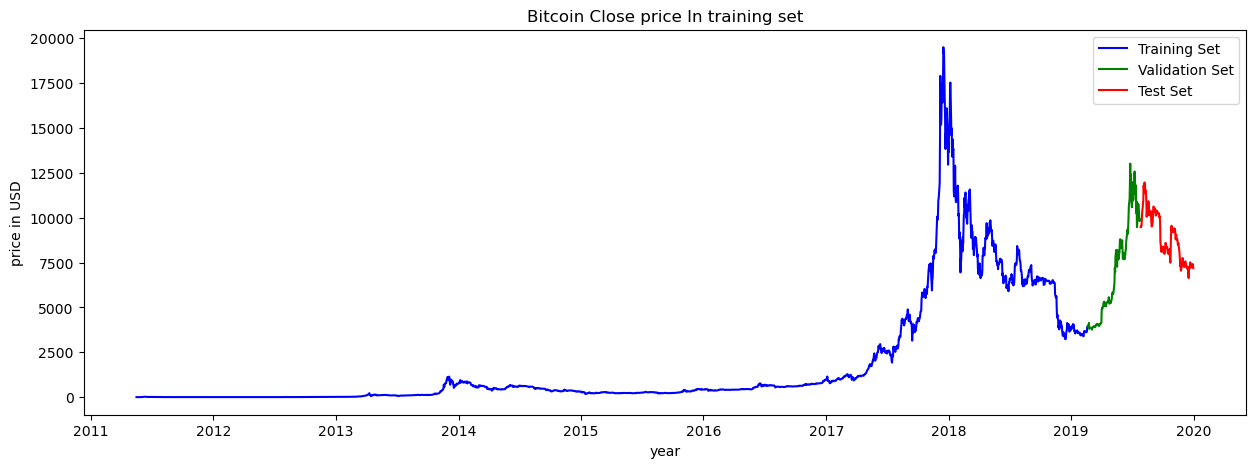

In [51]:
# Plotting ratio of training, validation and test set
plt.figure(figsize=(15, 5))

#plotting each the close price of bitcoin
data_RNN_1['date'] = pd.to_datetime(data_RNN_1['date'])

# Plot Training Data in Blue
plt.plot(data_RNN_1['date'][:2835], data_RNN_1['close'][:2835], color='blue', label='Training Data')

# Plot Validation data in Green
plt.plot(data_RNN_1['date'][2835:2993], data_RNN_1['close'][2835:2993], color='green', label='Validation Data')

# Plot Test Data in Red
plt.plot(data_RNN_1['date'][2993:], data_RNN_1['close'][2993:], color='red', label='Test Data')


plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Show labels for each year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format labels as 'YYYY'
plt.xlabel("year")
plt.ylabel("price in USD")
plt.title("Bitcoin Close price In training set")
plt.legend(['Training Set', 'Validation Set', 'Test Set'])
plt.show()

#### Variable Sacling by Min-Max  <br>
$$
X_{\text{scaled}} = \frac{X - X_{\min}}{X_{\max} - X_{\min}}
$$

Where:
- $X$ is the original value,
- $X_{\min}$ is the minimum value in the dataset,
- $X_{\max}$ is the maximum value in the dataset,
- $X_{\text{scaled}}$ is the transformed value.


In [53]:
scaler = MinMaxScaler(feature_range=(0, 1))

#SCALING TRAINSET X
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
#SCALING TRAINSET y
y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled = scaler.transform(y_val)
y_test_scaled = scaler.transform(y_test)

#### Spliting sequential data into input-output pairs for LSTM model

In [55]:
# Configurations of the generator
time_steps = 7 # The number of past days used for prediction
batch_size = 32 # Batch size for model training (Computational power Constraints)

# Generate input-output pairs 
train_generator = TimeseriesGenerator(X_train_scaled, y_train_scaled, length=time_steps, batch_size=batch_size)
val_generator = TimeseriesGenerator(X_val_scaled, y_val_scaled, length=time_steps, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test_scaled, y_test_scaled, length=time_steps, batch_size=batch_size)

In [57]:
# Verify the shape of input-output pairs
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"Shape of input-output pairs:{len(train_generator)}")

X_train_scaled shape: (2835, 13)
Shape of input-output pairs:89


##### In this project, we are going to use Long Short Term Memory Neural Network (LSTM)
- Captures long term dependencies better than other time-series models
- Avoid vanishing gradient problems

#### <a name = m1>MODEL 1</a>

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 12)             │         1,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,451 (5.67 KB)

 Trainable params: 1,451 (5.67 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
89/89 - 1s - 13ms/step - loss: 0.0182 - root_mean_squared_error: 0.1348 - val_loss: 0.0373 - val_root_mean_squared_error: 0.1932
Epoch 2/100
89/89 - 0s - 1ms/step - loss: 0.0055 - root_mean_squared_error: 0.0740 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1292
Epoch 3/100
89/89 - 0s - 1ms/step - loss: 0.0025 - root_mean_squared_error: 0.0495 - val_loss: 0.0274 - val_root_mean_squared_error: 0.1654
Epoch 4/100
89/89 - 0s - 1ms/step - loss: 0.0021 - root_mean_squared_error: 0.0462 - val_loss: 0.0190 - val_root_mean_squared_error: 0.1378
Epoch 5/100
89/89 - 0s - 1ms/step - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 0.0352 - val_root_mean_squared_error: 0.1877
Epoch 6/100
89/89 - 0s - 998us/step - loss: 0.0012 - root_mean_squared_error: 0.0347 - val_loss: 0.0368 - val_root_mean_squared_error: 0.1918
Epoch 7/100
89/89 - 0s - 998us/step - loss: 9.3196e-04 - root_mean_squared_error: 0.0305 - val_loss: 0.0215 - val_root_mean_squared_error: 0.1467
Epoch 8/100

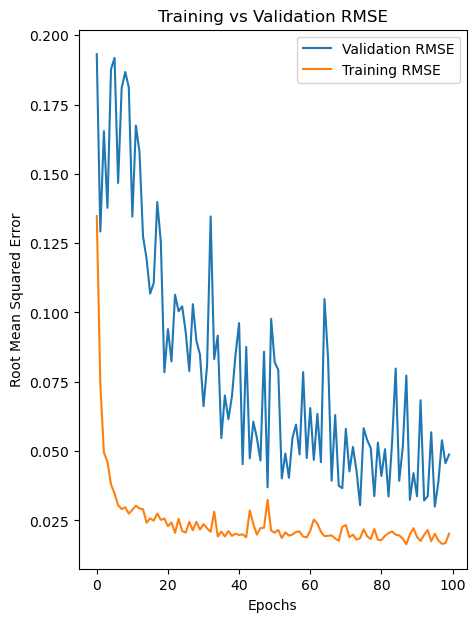

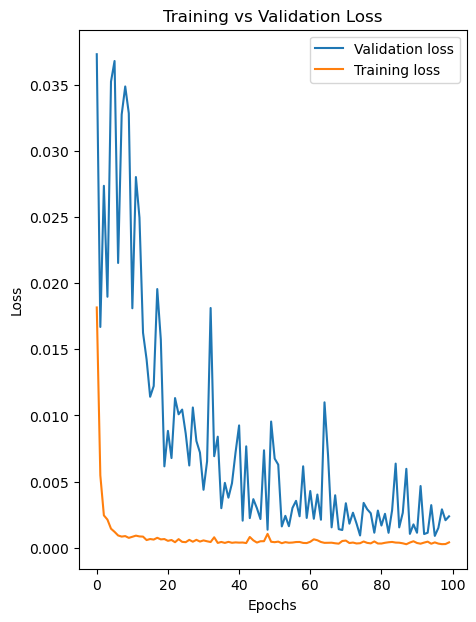

In [65]:
#MODEL 1
model1 = Sequential()
model1.add(LSTM(12, activation='tanh', input_shape=(time_steps, X_train_scaled.shape[1])))
model1.add(Dense(10, activation='tanh'))
model1.add(Dense(6,  activation='tanh'))
model1.add(Dense(1))
model1.summary()

# Define MSE loss function
model1.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Fit input-output pairs into the model and validate the model by validaion input-output pairs 
history1 = model1.fit(train_generator, epochs=100, batch_size=batch_size, verbose=2, validation_data=val_generator)

# Use RMSE to evaluate the perfromance 
val_rmse = history1.history['val_root_mean_squared_error']
train_rmse = history1.history['root_mean_squared_error']

# plotting comparison graph for training and validation to inspect the model training process and prevent overfitting
plt.figure(figsize=(5, 7))
plt.plot(val_rmse, label="Validation RMSE")
plt.plot(train_rmse, label="Training RMSE")
plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")
plt.legend()
plt.title("Training vs Validation RMSE")
plt.show()

val_loss = history1.history['val_loss']
train_loss = history1.history['loss']

plt.figure(figsize=(5, 7))
plt.plot(val_loss, label="Validation loss")
plt.plot(train_loss, label="Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

#### <a name = m2>MODEL 2</a>

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 8)              │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │            45 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 755 (2.95 KB)

 Trainable params: 755 (2.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
89/89 - 1s - 14ms/step - loss: 0.0208 - root_mean_squared_error: 0.1443 - val_loss: 0.0408 - val_root_mean_squared_error: 0.2020
Epoch 2/40
89/89 - 0s - 1ms/step - loss: 0.0171 - root_mean_squared_error: 0.1309 - val_loss: 0.0413 - val_root_mean_squared_error: 0.2031
Epoch 3/40
89/89 - 0s - 1ms/step - loss: 0.0141 - root_mean_squared_error: 0.1188 - val_loss: 0.0250 - val_root_mean_squared_error: 0.1581
Epoch 4/40
89/89 - 0s - 1ms/step - loss: 0.0121 - root_mean_squared_error: 0.1102 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1241
Epoch 5/40
89/89 - 0s - 999us/step - loss: 0.0112 - root_mean_squared_error: 0.1061 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1067
Epoch 6/40
89/89 - 0s - 983us/step - loss: 0.0090 - root_mean_squared_error: 0.0948 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0869
Epoch 7/40
89/89 - 0s - 979us/step - loss: 0.0093 - root_mean_squared_error: 0.0965 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0851
Epoch 8/40
89/89 - 0

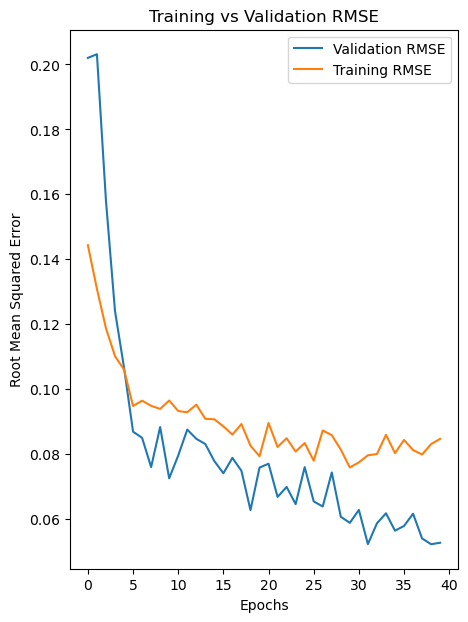

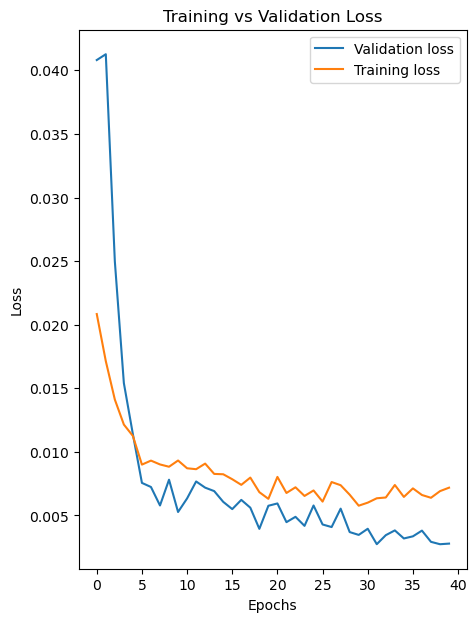

In [67]:
#MODEL 2
model2 = Sequential()
model2.add(LSTM(8, activation='relu', input_shape=(time_steps, X_train_scaled.shape[1]), ))
model2.add(Dropout(0.2))
model2.add(Dense(5,  activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1))
model2.summary()

# Define MSE loss function
model2.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Fit input-output pairs into the model and validate the model by validaion input-output pairs 
history2 = model2.fit(train_generator, epochs=40, batch_size=batch_size, verbose=2, validation_data=val_generator)

# Use RMSE to evaluate the perfromance 
val_rmse = history2.history['val_root_mean_squared_error']
train_rmse = history2.history['root_mean_squared_error']

# plotting comparison graph for training and validation to inspect the model training process and prevent overfitting
plt.figure(figsize=(5, 7))
plt.plot(val_rmse, label="Validation RMSE")
plt.plot(train_rmse, label="Training RMSE")
plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")
plt.legend()
plt.title("Training vs Validation RMSE")
plt.show()

val_loss = history2.history['val_loss']
train_loss = history2.history['loss']

plt.figure(figsize=(5, 7))
plt.plot(val_loss, label="Validation loss")
plt.plot(train_loss, label="Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

#### <a name = m3>MODEL 3</a>

In [69]:
#MODEL 3
model3 = Sequential()
model3.add(LSTM(64, activation='sigmoid', input_shape=(time_steps, X_train_scaled.shape[1]), ))
model3.add(Dropout(0.4))
model3.add(Dense(1))
model3.summary()

# Define MSE loss function
model3.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Fit input-output pairs into the model and validate the model by validaion input-output pairs 
history3 = model3.fit(train_generator, epochs=40, batch_size=batch_size, verbose=2, validation_data=val_generator)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
89/89 - 1s - 8ms/step - loss: 0.1307 - root_mean_squared_error: 0.3615 - val_loss: 0.0272 - val_root_mean_squared_error: 0.1650
Epoch 2/40
89/89 - 0s - 1ms/step - loss: 0.0699 - root_mean_squared_error: 0.2643 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1228
Epoch 3/40
89/89 - 0s - 1ms/step - loss: 0.0436 - root_mean_squared_error: 0.2088 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0857
Epoch 4/40
89/89 - 0s - 1ms/step - loss: 0.0321 - root_mean_squared_error: 0.1791 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0735
Epoch 5/40
89/89 - 0s - 1ms/step - loss: 0.0236 - root_mean_squared_error: 0.1535 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0753
Epoch 6/40
89/89 - 0s - 1ms/step - loss: 0.0191 - root_mean_squared_error: 0.1381 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0631
Epoch 7/40
89/89 - 0s - 1ms/step - loss: 0.0173 - root_mean_squared_error: 0.1315 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0600
Epoch 8/40
89/89 - 0s - 1ms

### In the following part, we try to use L2 regularization method to reduce the risk of overfitting.

### Regularized Models

#### <a name = m4>MODEL 4</a>

In [73]:
from keras.regularizers import L2

In [74]:
#MODEL 4
model4 = Sequential()
model4.add(LSTM(64, activation='sigmoid', kernel_regularizer=L2(0.01), recurrent_regularizer=L2(0.01), input_shape=(time_steps, X_train_scaled.shape[1]), ))
model4.add(Dropout(0.25))
model4.add(Dense(1))
model4.summary()

# Define MSE loss function
model4.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Fit input-output pairs into the model and validate the model by validaion input-output pairs 
history4 = model4.fit(train_generator, epochs=40, batch_size=batch_size, verbose=2, validation_data=val_generator)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
89/89 - 1s - 8ms/step - loss: 0.5205 - root_mean_squared_error: 0.2978 - val_loss: 0.2254 - val_root_mean_squared_error: 0.2299
Epoch 2/40
89/89 - 0s - 2ms/step - loss: 0.1569 - root_mean_squared_error: 0.2521 - val_loss: 0.0811 - val_root_mean_squared_error: 0.1809
Epoch 3/40
89/89 - 0s - 2ms/step - loss: 0.0848 - root_mean_squared_error: 0.2286 - val_loss: 0.0769 - val_root_mean_squared_error: 0.2323
Epoch 4/40
89/89 - 0s - 2ms/step - loss: 0.0666 - root_mean_squared_error: 0.2191 - val_loss: 0.0285 - val_root_mean_squared_error: 0.1122
Epoch 5/40
89/89 - 0s - 1ms/step - loss: 0.0583 - root_mean_squared_error: 0.2115 - val_loss: 0.0392 - val_root_mean_squared_error: 0.1618
Epoch 6/40
89/89 - 0s - 2ms/step - loss: 0.0541 - root_mean_squared_error: 0.2048 - val_loss: 0.0357 - val_root_mean_squared_error: 0.1560
Epoch 7/40
89/89 - 0s - 2ms/step - loss: 0.0500 - root_mean_squared_error: 0.1983 - val_loss: 0.0687 - val_root_mean_squared_error: 0.2407
Epoch 8/40
89/89 - 0s - 2ms

#### <a name = m5>MODEL 5</a>

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 8)              │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │            45 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 755 (2.95 KB)

 Trainable params: 755 (2.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
89/89 - 1s - 9ms/step - loss: 0.2103 - root_mean_squared_error: 0.1226 - val_loss: 0.1767 - val_root_mean_squared_error: 0.1931
Epoch 2/100
89/89 - 0s - 1ms/step - loss: 0.1134 - root_mean_squared_error: 0.0975 - val_loss: 0.0937 - val_root_mean_squared_error: 0.1360
Epoch 3/100
89/89 - 0s - 1ms/step - loss: 0.0638 - root_mean_squared_error: 0.0845 - val_loss: 0.0511 - val_root_mean_squared_error: 0.0968
Epoch 4/100
89/89 - 0s - 1ms/step - loss: 0.0384 - root_mean_squared_error: 0.0793 - val_loss: 0.0328 - val_root_mean_squared_error: 0.0928
Epoch 5/100
89/89 - 0s - 1ms/step - loss: 0.0250 - root_mean_squared_error: 0.0745 - val_loss: 0.0255 - val_root_mean_squared_error: 0.1010
Epoch 6/100
89/89 - 0s - 1ms/step - loss: 0.0182 - root_mean_squared_error: 0.0739 - val_loss: 0.0172 - val_root_mean_squared_error: 0.0817
Epoch 7/100
89/89 - 0s - 995us/step - loss: 0.0141 - root_mean_squared_error: 0.0713 - val_loss: 0.0123 - val_root_mean_squared_error: 0.0663
Epoch 8/100
89/89 

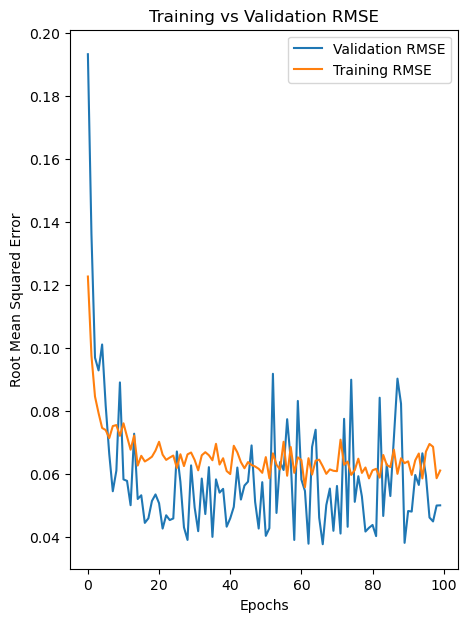

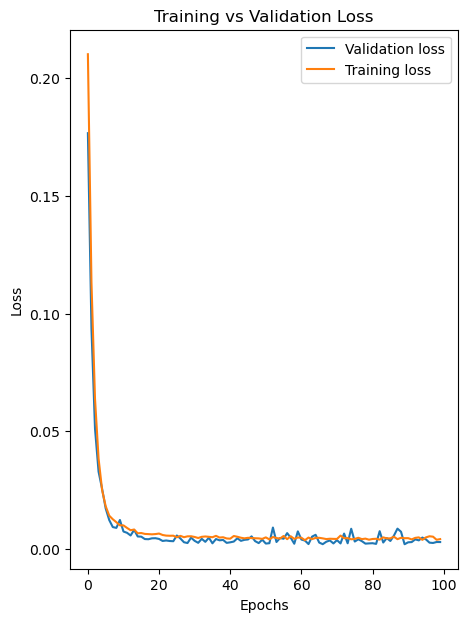

In [76]:
#MODEL 5
model5 = Sequential()
model5.add(LSTM(8, activation='relu', kernel_regularizer=L2(0.01), recurrent_regularizer=L2(0.01), input_shape=(time_steps, X_train_scaled.shape[1]), ))
model5.add(Dropout(0.2))
model5.add(Dense(5,  activation='relu'))
model5.add(Dropout(0.2))
model5.add(Dense(1))
model5.summary()

# Define MSE loss function
model5.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Fit input-output pairs into the model and validate the model by validaion input-output pairs 
history5 = model5.fit(train_generator, epochs=100, batch_size=batch_size, verbose=2, validation_data=val_generator)

# Use RMSE to evaluate the perfromance 
val_rmse = history5.history['val_root_mean_squared_error']
train_rmse = history5.history['root_mean_squared_error']

# plotting comparison graph for training and validation to inspect the model training process and prevent overfitting
plt.figure(figsize=(5, 7))
plt.plot(val_rmse, label="Validation RMSE")
plt.plot(train_rmse, label="Training RMSE")
plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")
plt.legend()
plt.title("Training vs Validation RMSE")
plt.show()

val_loss = history5.history['val_loss']
train_loss = history5.history['loss']

plt.figure(figsize=(5, 7))
plt.plot(val_loss, label="Validation loss")
plt.plot(train_loss, label="Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

#### <a name = m6>MODEL 6</a>

In [79]:
#MODEL 6
from tensorflow.keras.layers import GRU

# Use a simplier model (GRU) to evaluate the perfromance
model6 = Sequential([
    GRU(64, return_sequences=False,
        kernel_regularizer=L2(0.001),
        recurrent_regularizer=L2(0.001),
        dropout=0.4,
        recurrent_dropout=0.4,
        input_shape=(time_steps, X_train_scaled.shape[1])),
    Dense(1)])
model6.summary()

# Define MSE loss function
model6.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Fit input-output pairs into the model and validate the model by validaion input-output pairs 
history6 = model6.fit(train_generator, epochs=100, batch_size=batch_size, verbose=2, validation_data=val_generator)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        15,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,233 (59.50 KB)

 Trainable params: 15,233 (59.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
89/89 - 1s - 16ms/step - loss: 0.0909 - root_mean_squared_error: 0.1724 - val_loss: 0.0430 - val_root_mean_squared_error: 0.0439
Epoch 2/100
89/89 - 0s - 2ms/step - loss: 0.0396 - root_mean_squared_error: 0.0869 - val_loss: 0.0307 - val_root_mean_squared_error: 0.0718
Epoch 3/100
89/89 - 0s - 3ms/step - loss: 0.0280 - root_mean_squared_error: 0.0780 - val_loss: 0.0233 - val_root_mean_squared_error: 0.0656
Epoch 4/100
89/89 - 0s - 2ms/step - loss: 0.0222 - root_mean_squared_error: 0.0719 - val_loss: 0.0188 - val_root_mean_squared_error: 0.0599
Epoch 5/100
89/89 - 0s - 2ms/step - loss: 0.0198 - root_mean_squared_error: 0.0767 - val_loss: 0.0156 - val_root_mean_squared_error: 0.0544
Epoch 6/100
89/89 - 0s - 2ms/step - loss: 0.0169 - root_mean_squared_error: 0.0724 - val_loss: 0.0166 - val_root_mean_squared_error: 0.0764
Epoch 7/100
89/89 - 0s - 2ms/step - loss: 0.0152 - root_mean_squared_error: 0.0727 - val_loss: 0.0389 - val_root_mean_squared_error: 0.1722
Epoch 8/100
89/89 -

#### <a name = m7>MODEL 7</a>

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │           325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,299 (79.29 KB)

 Trainable params: 20,299 (79.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
89/89 - 1s - 8ms/step - loss: 0.0183 - root_mean_squared_error: 0.1352 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0544
Epoch 2/100
89/89 - 0s - 1ms/step - loss: 0.0062 - root_mean_squared_error: 0.0787 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0449
Epoch 3/100
89/89 - 0s - 1ms/step - loss: 0.0053 - root_mean_squared_error: 0.0730 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0845
Epoch 4/100
89/89 - 0s - 1ms/step - loss: 0.0048 - root_mean_squared_error: 0.0692 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0580
Epoch 5/100
89/89 - 0s - 1ms/step - loss: 0.0049 - root_mean_squared_error: 0.0699 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1096
Epoch 6/100
89/89 - 0s - 1ms/step - loss: 0.0047 - root_mean_squared_error: 0.0685 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0363
Epoch 7/100
89/89 - 0s - 2ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0751
Epoch 8/100
89/89 - 

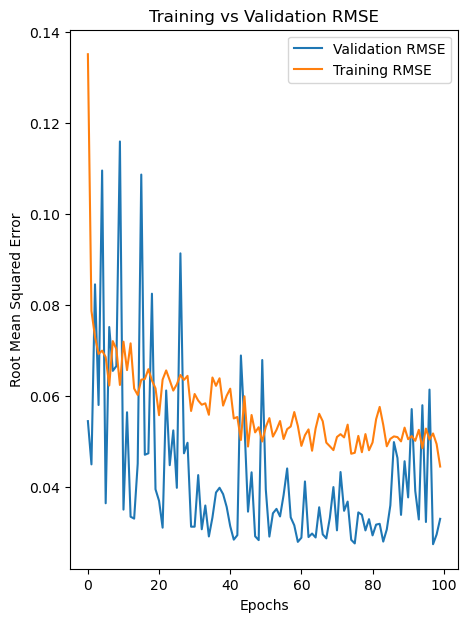

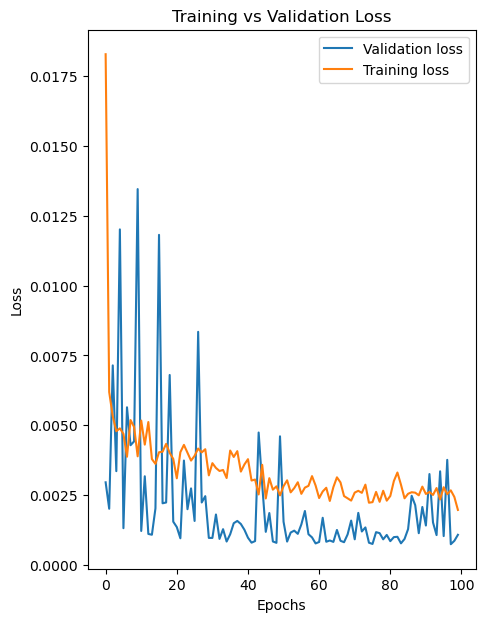

In [81]:
#MODEL 7
model7 = Sequential()
model7.add(LSTM(64, activation='relu', input_shape=(time_steps, X_train_scaled.shape[1]), ))
model7.add(Dropout(0.2))
model7.add(Dense(5,  activation='relu'))
model7.add(Dropout(0.2))
model7.add(Dense(1))
model7.summary()

# Define MSE loss function
model7.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Fit input-output pairs into the model and validate the model by validaion input-output pairs 
history7 = model7.fit(train_generator, epochs=100, batch_size=batch_size, verbose=2, validation_data=val_generator)

# Use RMSE to evaluate the perfromance 
val_rmse = history7.history['val_root_mean_squared_error']
train_rmse = history7.history['root_mean_squared_error']

# plotting comparison graph for training and validation to inspect the model training process and prevent overfitting
plt.figure(figsize=(5, 7))
plt.plot(val_rmse, label="Validation RMSE")
plt.plot(train_rmse, label="Training RMSE")
plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")
plt.legend()
plt.title("Training vs Validation RMSE")
plt.show()

val_loss = history7.history['val_loss']
train_loss = history7.history['loss']

plt.figure(figsize=(5, 7))
plt.plot(val_loss, label="Validation loss")
plt.plot(train_loss, label="Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

#### <a name = m8>MODEL 8</a>

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 128)            │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 24)             │         3,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,825 (296.19 KB)

 Trainable params: 75,825 (296.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
89/89 - 1s - 12ms/step - loss: 0.0136 - root_mean_squared_error: 0.1168 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1106
Epoch 2/100
89/89 - 0s - 3ms/step - loss: 0.0080 - root_mean_squared_error: 0.0894 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0723
Epoch 3/100
89/89 - 0s - 3ms/step - loss: 0.0064 - root_mean_squared_error: 0.0798 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 4/100
89/89 - 0s - 3ms/step - loss: 0.0067 - root_mean_squared_error: 0.0820 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0572
Epoch 5/100
89/89 - 0s - 3ms/step - loss: 0.0052 - root_mean_squared_error: 0.0722 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0480
Epoch 6/100
89/89 - 0s - 3ms/step - loss: 0.0061 - root_mean_squared_error: 0.0782 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0827
Epoch 7/100
89/89 - 0s - 3ms/step - loss: 0.0054 - root_mean_squared_error: 0.0736 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0880
Epoch 8/100
89/89 -

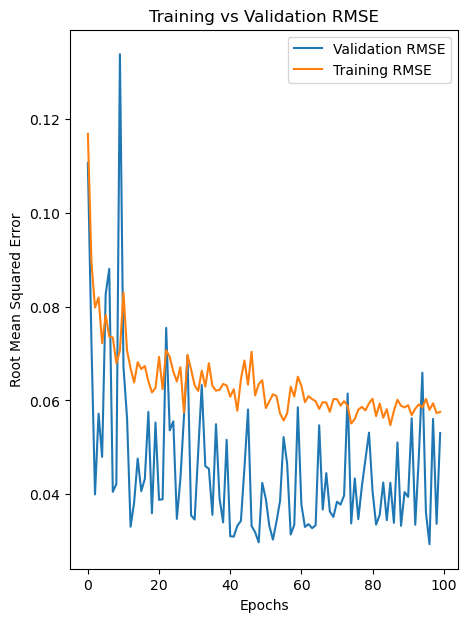

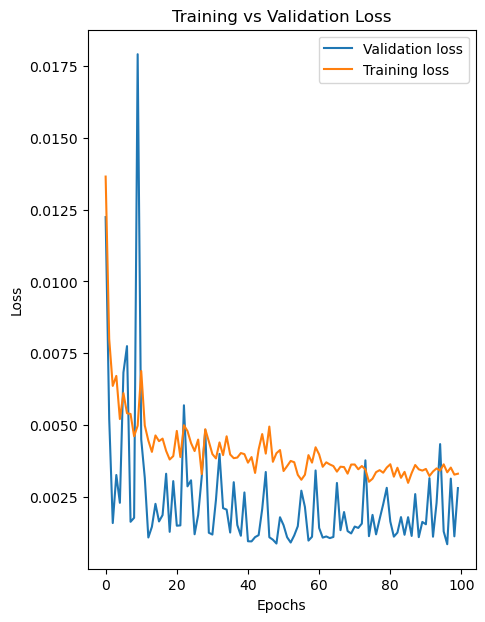

In [83]:
#MODEL 8
model8 = Sequential()
model8.add(LSTM(128, activation='relu', input_shape=(time_steps, X_train_scaled.shape[1]), ))
model8.add(Dropout(0.5))
model8.add(Dense(24,  activation='relu'))
model8.add(Dropout(0.5))
model8.add(Dense(1))
model8.summary()

# Define MSE loss function
model8.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Fit input-output pairs into the model and validate the model by validaion input-output pairs
history8 = model8.fit(train_generator, epochs=100, batch_size=batch_size, verbose=2, validation_data=val_generator)

# Use RMSE to evaluate the perfromance
val_rmse = history8.history['val_root_mean_squared_error']
train_rmse = history8.history['root_mean_squared_error']

# plotting comparison graph for training and validation to inspect the model training process and prevent overfitting
plt.figure(figsize=(5, 7))
plt.plot(val_rmse, label="Validation RMSE")
plt.plot(train_rmse, label="Training RMSE")
plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")
plt.legend()
plt.title("Training vs Validation RMSE")
plt.show()

val_loss = history8.history['val_loss']
train_loss = history8.history['loss']

plt.figure(figsize=(5, 7))
plt.plot(val_loss, label="Validation loss")
plt.plot(train_loss, label="Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

#### <a name = m9>MODEL 9</a>

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 128)            │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 6)              │           774 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,485 (287.05 KB)

 Trainable params: 73,485 (287.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
89/89 - 1s - 12ms/step - loss: 0.0209 - root_mean_squared_error: 0.1446 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1245
Epoch 2/100
89/89 - 0s - 3ms/step - loss: 0.0125 - root_mean_squared_error: 0.1116 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1454
Epoch 3/100
89/89 - 0s - 3ms/step - loss: 0.0142 - root_mean_squared_error: 0.1191 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1093
Epoch 4/100
89/89 - 0s - 3ms/step - loss: 0.0101 - root_mean_squared_error: 0.1003 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0928
Epoch 5/100
89/89 - 0s - 3ms/step - loss: 0.0098 - root_mean_squared_error: 0.0988 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 6/100
89/89 - 0s - 3ms/step - loss: 0.0113 - root_mean_squared_error: 0.1064 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1190
Epoch 7/100
89/89 - 0s - 3ms/step - loss: 0.0104 - root_mean_squared_error: 0.1020 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0658
Epoch 8/100
89/89 -

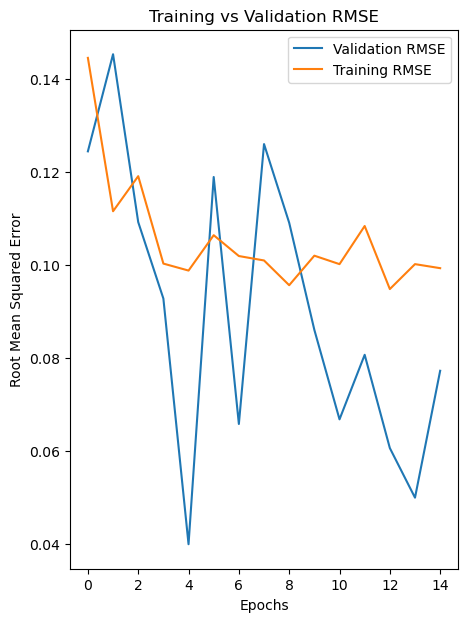

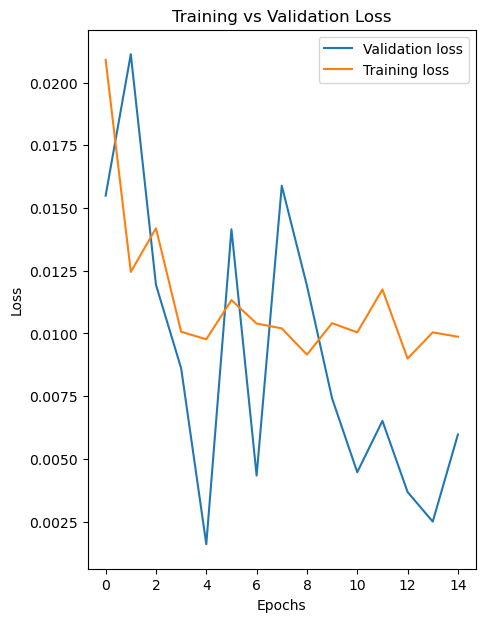

In [85]:
#MODEL 9
model9 = Sequential()
model9.add(LSTM(128, activation='relu', input_shape=(time_steps, X_train_scaled.shape[1]), ))
model9.add(Dropout(0.6))
model9.add(Dense(6,  activation='relu'))
model9.add(Dropout(0.6))
model9.add(Dense(1))
model9.summary()

from tensorflow.keras.callbacks import EarlyStopping

# Use early stopping to stop the training model when there is no improvement
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define MSE loss function
model9.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Fit input-output pairs into the model and validate the model by validaion input-output pairs
history9 = model9.fit(train_generator, epochs=100, batch_size=batch_size, verbose=2, validation_data=val_generator, callbacks=[early_stopping])

# Use RMSE to evaluate the perfromance
val_rmse = history9.history['val_root_mean_squared_error']
train_rmse = history9.history['root_mean_squared_error']

# plotting comparison graph for training and validation to inspect the model training process and prevent overfitting
plt.figure(figsize=(5, 7))
plt.plot(val_rmse, label="Validation RMSE")
plt.plot(train_rmse, label="Training RMSE")
plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")
plt.legend()
plt.title("Training vs Validation RMSE")
plt.show()

val_loss = history9.history['val_loss']
train_loss = history9.history['loss']

plt.figure(figsize=(5, 7))
plt.plot(val_loss, label="Validation loss")
plt.plot(train_loss, label="Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

#### Model 10

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 128)            │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,025 (316.50 KB)

 Trainable params: 81,025 (316.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
89/89 - 1s - 10ms/step - loss: 0.0063 - root_mean_squared_error: 0.0795 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0850
Epoch 2/100
89/89 - 0s - 3ms/step - loss: 0.0012 - root_mean_squared_error: 0.0352 - val_loss: 0.0307 - val_root_mean_squared_error: 0.1751
Epoch 3/100
89/89 - 0s - 3ms/step - loss: 9.1858e-04 - root_mean_squared_error: 0.0303 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1143
Epoch 4/100
89/89 - 0s - 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0452 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0884
Epoch 5/100
89/89 - 0s - 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0407 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 6/100
89/89 - 0s - 3ms/step - loss: 0.0010 - root_mean_squared_error: 0.0322 - val_loss: 9.6623e-04 - val_root_mean_squared_error: 0.0311
Epoch 7/100
89/89 - 0s - 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0376 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0974
Epoch 8/100

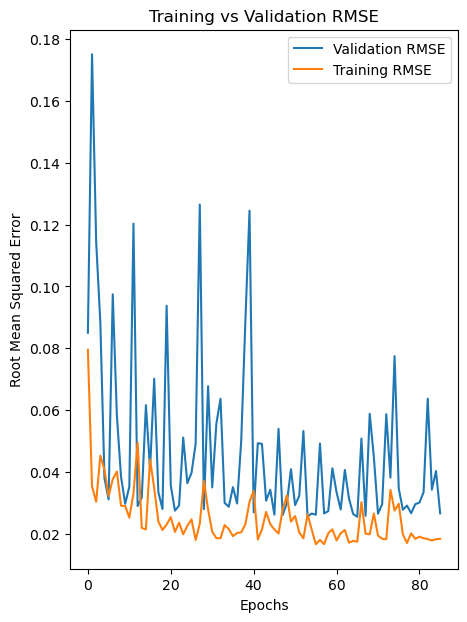

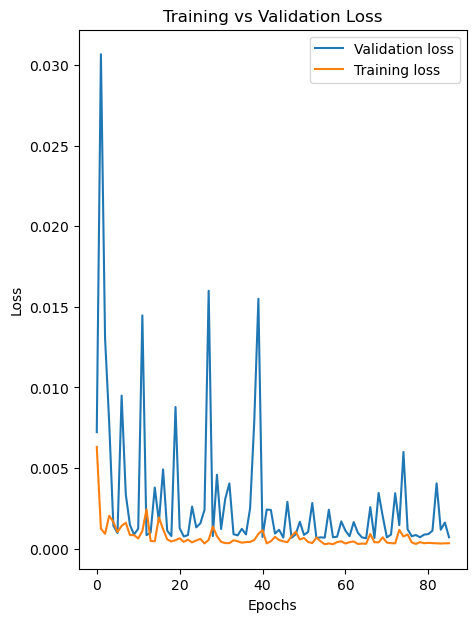

In [168]:
from tensorflow.keras.callbacks import EarlyStopping
#MODEL 10
model10 = Sequential()
model10.add(LSTM(128,input_shape=(time_steps, X_train_scaled.shape[1]), ))
model10.add(Dense(64))
model10.add(Dense(1))
model10.summary()

# Use early stopping to stop the training model when there is no improvement
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Define MSE loss function
model10.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Fit input-output pairs into the model and validate the model by validaion input-output pairs
history10 = model10.fit(train_generator, epochs=100, batch_size=batch_size, verbose=2, validation_data=val_generator, callbacks=[early_stopping])

# Use RMSE to evaluate the perfromance
val_rmse = history10.history['val_root_mean_squared_error']
train_rmse = history10.history['root_mean_squared_error']

# plotting comparison graph for training and validation to inspect the model training process and prevent overfitting
plt.figure(figsize=(5, 7))
plt.plot(val_rmse, label="Validation RMSE")
plt.plot(train_rmse, label="Training RMSE")
plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")
plt.legend()
plt.title("Training vs Validation RMSE")
plt.show()

val_loss = history10.history['val_loss']
train_loss = history10.history['loss']

plt.figure(figsize=(5, 7))
plt.plot(val_loss, label="Validation loss")
plt.plot(train_loss, label="Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

#### <a name = c1>Results</a>

In [180]:
# Locating the best model based on rmse and validation loss

history_list = [history1, history2,history3,history4,history5,history6,history7,history8,history9,history10]


last_rmse = []
last_loss = []
for i in history_list:
  val_rmse = i.history['val_root_mean_squared_error'][-1]
  val_loss = i.history['val_loss'][-1]
  last_rmse.append(val_rmse)
  last_loss.append(val_loss)

Best_model_rmse = np.argmin(last_rmse)+1
Best_model_last_loss = np.argmin(last_loss)+1

print(f'Best model according to validation rmse: Model {Best_model_rmse}\nBest model according to validation loss: Model {Best_model_last_loss}')

Best model according to validation rmse: Model 10
Best model according to validation loss: Model 10


In [182]:
# Drop the first 7 rows to match the prediction
y_test_dropped = y_test[7:]
y_test_dropped.reset_index()

# Match the length of prediction and actual price
len(y_test_dropped)

151

##### **Use cosine similarity to evaluate the model performance**
Cosine similarity is used as the importance of capturing the direction of price movements (upward or downward trends) is higher than predicting the exact value. 

##### **Cosine Similarity Formula:**
$$
\cos(\theta) = \frac{\sum_{i=1}^{n} y_i \hat{y}_i}{\sqrt{\sum_{i=1}^{n} y_i^2} \cdot \sqrt{\sum_{i=1}^{n} \hat{y}_i^2}}
$$
where:  
-  $ y_i $ are the actual values,  
- $ \hat{y}_i$ are the predicted values,  
- $ n $ is the number of samples.

This formula computes the cosine of the angle between the actual and predicted vectors, with values ranging from **-1** (completely opposite) to **1** (perfectly aligned).





In [185]:
# Perform prediction using the best model
prediction1 = model10.predict(test_generator, verbose=0)

# Reverse the scaling of the response variables 
scaled_prediction1 = scaler.inverse_transform(prediction1)
len(scaled_prediction1)

151

In [223]:
# Best model cosine similarity
act = np.array(y_test_dropped).ravel()
pred = np.array(scaled_prediction1).ravel()

dot_product = np.dot(act,pred)

norm_act =np.linalg.norm(act)
norm_pred =np.linalg.norm(pred)

norm_prod = norm_act*norm_pred

print(f'cosine_similarity best model: {dot_product/norm_prod}')

cosine_similarity best model: 0.9989624065512674


##### **Using RMSE to evaluate the model performance**

##### **Root Mean Squared Error (RMSE) Formula:**
$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$
where:  
- $ y_i $ are the actual values,  
- $ \hat{y}_i $ are the predicted values,  
- $ n $ is the number of samples.

This formula measures how far off the predictions are from the actual values, with a lower RMSE indicating better accuracy.


In [209]:
import sklearn.metrics
# Best model RMSE
rms_best_model = sklearn.metrics.mean_squared_error(act, pred, sample_weight=None, multioutput='uniform_average')

# Baseline model (using mean for prediction) RMSE
y_pred = np.full_like(act, act.mean())
rms_baseline = sklearn.metrics.mean_squared_error(act, y_pred)


print(f"RMSE for baseline model (pred using mean): {rms}. \nRMSE for best model (Model 10): {rms_best_model}")

RMSE for baseline model (pred using mean): 1817477.6074888445. 
RMSE for best model (Model 10): 182986.4193954302


RMSE of the best model is more than 9 times lower than the baseline model.

##### **Plotting the results**

In [215]:
# Predictions of validation dataset for plotting
val_predictions = model10.predict(val_generator)
val_scaled_prediction = scaler.inverse_transform(val_predictions)
len(val_scaled_prediction)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


151

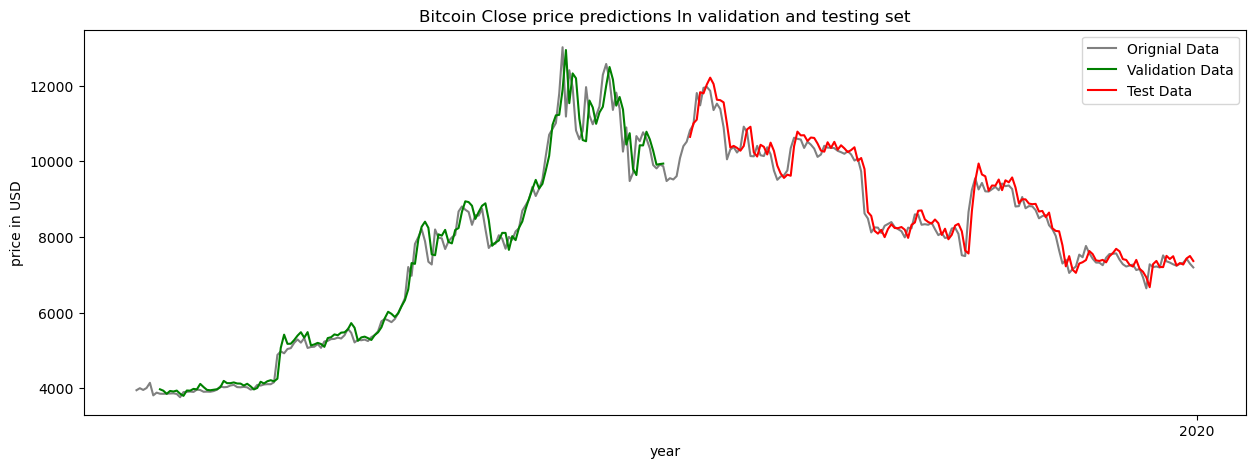

In [217]:
plt.figure(figsize=(15, 5))

#plotting each the close price of bitcoin
data_RNN_1['date'] = pd.to_datetime(data_RNN_1['date'])

# Plot Full Data (Faded Color for Context)
plt.plot(data_RNN_1['date'][2835:], data_RNN_1['close'][2835:], color='gray', alpha=1, label='Orignial Data')


# Plot Validation data in Green
plt.plot(data_RNN_1['date'][2842:2993], val_scaled_prediction, color='green', label='Validation Data')

# Plot Test Data in Red
plt.plot(data_RNN_1['date'][3000:], pred, color='red', label='Test Data')


plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Show labels for each year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format labels as 'YYYY'
plt.xlabel("year")
plt.legend()
plt.ylabel("price in USD")
plt.title("Bitcoin Close price predictions In validation and testing set")
plt.show()

## <a name = 6>Limitations</a>

- **Data constraints**: Due to time and computational constraints, we could not scrape data from reddit for the entire time period from 2011-2025. Also for energy prices, we can only access monthly price rather than daily prices, which might lower the accuracy <br><br>
- **lack Swan Events**: Unpredictable external shocks (e.g., regulatory changes, exchange hacks) are not captured in the feature set, reducing forecast accuracy during crises.<br><br>
- **Lagging Indicators**: Technical metrics like RSI and MACD are inherently backward-looking and may fail to anticipate sudden market shifts (e.g., flash crashes).<br><br>

Thats the end of Bitcoin prediction project, thanks for reading!